<a href="https://colab.research.google.com/github/r-ogrady/demos_vis_geospatial/blob/main/c25_train2_AMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes
* **Purpose:** train AudioMNIST data with preprocessed specs, different alpha, layer type and lr
* Desired label = digit, orthog label = gender
* Slight changes to preprocessing from before
* **Note:** this experiment is abandoned because the base manages to score close to 100%!

In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import copy
import random
import gc
from google.colab import drive
import sys
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
# in colab - mount drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Dissertation/code'
sys.path.append("drive/My Drive/Dissertation/code")

Mounted at /content/drive/
/content/drive/My Drive/Dissertation/code


In [3]:
from b01_cpl import CorrelationPenaltyLoss
from b02_models import AlexNet
from b03_plotters import plotter0, plotter, plotter_corr

# Helper functions and initialisations
For training, plotting training metrics and checking accuracy on test set

In [4]:
# random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
generator1=torch.Generator().manual_seed(42)


In [28]:
# trainer with my loss
def trainer0(n_epochs,lrs,train_dataloader,val_dataloader):

    # storage
    # data dict for storing metrics per lr and epoch
    epoch_keys=["train_losses","train_accuracies",
                "val_losses","val_accuracies","time"]

    best_model_strings=[]

    data_dict={lr:
      {key:[] for key in epoch_keys} for lr in lrs}

    # we train a new model for each lr value
    for i,lr in enumerate(lrs):
        # load model for each loop
        model = AlexNet(input_channels=1).to(device)
        optimizer = optim.Adam(params = model.parameters(),lr=lr)
        criterion = nn.CrossEntropyLoss()

        # initialise variables for EarlyStopping
        best_loss = float('inf')
        best_model_weights = None
        patience = 10


        print(f"training for lr = {lr}")

        for epoch in range(n_epochs):
            t0 = time.time()
            # initialise variables for recording training loss and accuracy
            running_loss = 0.0
            running_loss_base = 0.0
            running_correct = 0
            running_total = 0

            model.train()
            for input,labels in train_dataloader:
                desired_labels=labels[0]

                input = input.to(device)
                desired_labels = desired_labels.to(device)


                optimizer.zero_grad()
                output = model(input)
                loss = criterion(output,desired_labels)
                loss.backward()
                optimizer.step()

                # training loss and accuracy for batch
                # this is scaled by the batch size and divided back later
                running_loss += loss.item() * input.size(0)

                _, predicted = torch.max(output.data, 1)
                running_total += desired_labels.size(0)
                running_correct += (predicted == desired_labels).sum().item()

            # training loss and accuracy for epoch (scaled back)
            train_loss = running_loss/len(train_dataloader.dataset)

            train_accuracy = 100 * running_correct/running_total

            # store
            epoch_dict=data_dict[lr]
            epoch_dict["train_losses"].append(train_loss)

            epoch_dict["train_accuracies"].append(train_accuracy)

            # initialise variables for recording val loss and accuracy
            val_running_loss = 0.0
            val_running_correct = 0
            val_running_total = 0

            model.eval()
            with torch.no_grad():
                for input,labels in val_dataloader:
                    desired_labels=labels[0]
                    input = input.to(device)
                    desired_labels = desired_labels.to(device)

                    output = model(input)

                    # validation loss and accuracy for batch
                    val_running_loss += criterion(output,desired_labels).item() * desired_labels.size(0)

                    _, predicted = torch.max(output.data, 1)
                    val_running_total += desired_labels.size(0)
                    val_running_correct += (predicted == desired_labels).sum().item()


            # validation loss and accuracy for epoch
            val_loss = val_running_loss / len(val_dataloader.dataset)

            val_accuracy = 100 * val_running_correct / val_running_total

            # store
            epoch_time=time.time()-t0
            epoch_dict["val_losses"].append(val_loss)

            epoch_dict["val_accuracies"].append(val_accuracy)
            epoch_dict["time"].append(epoch_time)

            # print for epoch
            if epoch % 5 == 0:
                print(f"epoch: {epoch + 1}, time: {epoch_time:0.2f}")
                print("training loss: ",
                      f"{train_loss:0.2f}, accuracy: {train_accuracy:.2f}")
                print("validation loss: ",
                      f"{val_loss:0.2f}, accuracy: {val_accuracy:.2f}")
                print()

            # EarlyStopping
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_weights = copy.deepcopy(model.state_dict())
                patience = 10
            else:
                patience -= 1
                if patience == 0:
                    print(f"Early stop at epoch {epoch+1}\n")
                    break

        # load and store the best model weights
        model.load_state_dict(best_model_weights)
        time_stamp=time.strftime("%Y%m%d-%H%M%S")
        file_path=f"output/model_base_lr{lr}_{time_stamp}.pth"
        torch.save(model.state_dict(), file_path)
        print(f"saved model as '{file_path}'")
        print()
        best_model_strings.append(file_path)

    return data_dict, best_model_strings


In [29]:
def trainer(n_epochs, lrs, alphas, layer_type, train_dataloader, val_dataloader):

    # storage
    # data dict for storing metrics per alpha and epoch
    epoch_keys = ["train_losses_base", "train_losses_corr", "train_losses", "train_accuracies",
                  "val_losses_base", "val_losses_corr", "val_losses", "val_accuracies", "time"]
    best_model_strings=[]

    # we train a new batch of models for each lr
    lr_dict = {}
    for i, lr in enumerate(lrs):
        print(f"training for lr = {lr}")

        # Create a new alpha_dict for each lr
        alpha_dict = {alpha: {key: [] for key in epoch_keys} for alpha in alphas}

        # we train a new model for each alpha value
        for alpha in alphas:
            # load model for each loop
            model = AlexNet(input_channels=1).to(device)
            optimizer = optim.Adam(params=model.parameters(), lr=lr)
            criterion = CorrelationPenaltyLoss(model=model,
                                               base_loss_fn=base_loss_fn,
                                               layer_type=layer_type,
                                               alpha=alpha)

            # initialise variables for EarlyStopping
            best_loss = float('inf')
            best_model_weights = None
            patience = 10

            print(f"training for alpha = {alpha}")

            for epoch in range(n_epochs):
                # clear cache before starting a new model training
                torch.cuda.empty_cache()

                t0 = time.time()
                # initialise variables for recording training loss and accuracy
                running_loss = 0.0
                running_loss_base = 0.0
                running_correct = 0
                running_total = 0

                model.train()
                for input, labels in train_dataloader:
                    desired_labels = labels[0]
                    orthog_labels = labels[1]
                    input = input.to(device)
                    desired_labels = desired_labels.to(device)
                    orthog_labels = orthog_labels.to(device)

                    optimizer.zero_grad()
                    output = model(input)
                    loss = criterion(output, desired_labels, orthog_labels)
                    loss_base = base_loss_fn(output, desired_labels)
                    loss.backward()
                    optimizer.step()

                    # training loss and accuracy for batch
                    # this is scaled by the batch size and divided back later
                    running_loss += loss.item() * input.size(0)
                    running_loss_base += loss_base.item() * input.size(0)
                    _, predicted = torch.max(output.data, 1)
                    running_total += desired_labels.size(0)
                    running_correct += (predicted == desired_labels).sum().item()

                # training loss and accuracy for epoch (scaled back)
                train_loss = running_loss / len(train_dataloader.dataset)
                train_loss_base = running_loss_base / len(train_dataloader.dataset)
                train_loss_corr = (train_loss - train_loss_base) / alpha
                train_accuracy = 100 * running_correct / running_total

                # store
                epoch_dict = alpha_dict[alpha]
                epoch_dict["train_losses"].append(train_loss)
                epoch_dict["train_losses_corr"].append(train_loss_corr)
                epoch_dict["train_losses_base"].append(train_loss_base)
                epoch_dict["train_accuracies"].append(train_accuracy)

                # initialise variables for recording val loss and accuracy
                val_running_loss = 0.0
                val_running_loss_base = 0.0
                val_running_correct = 0
                val_running_total = 0

                model.eval()
                with torch.no_grad():
                    for input, labels in val_dataloader:
                        desired_labels = labels[0]
                        orthog_labels = labels[1]
                        input = input.to(device)
                        desired_labels = desired_labels.to(device)
                        orthog_labels = orthog_labels.to(device)

                        output = model(input)

                        # validation loss and accuracy for batch
                        val_running_loss += criterion(output, desired_labels, orthog_labels).item() * desired_labels.size(0)
                        val_running_loss_base += base_loss_fn(output, desired_labels).item() * desired_labels.size(0)
                        _, predicted = torch.max(output.data, 1)
                        val_running_total += desired_labels.size(0)
                        val_running_correct += (predicted == desired_labels).sum().item()

                # validation loss and accuracy for epoch
                val_loss = val_running_loss / len(val_dataloader.dataset)
                val_loss_base = val_running_loss_base / len(val_dataloader.dataset)
                val_loss_corr = (val_loss - val_loss_base) / alpha
                val_accuracy = 100 * val_running_correct / val_running_total

                # store
                epoch_time = time.time() - t0
                epoch_dict["val_losses"].append(val_loss)
                epoch_dict["val_losses_corr"].append(val_loss_corr)
                epoch_dict["val_losses_base"].append(val_loss_base)
                epoch_dict["val_accuracies"].append(val_accuracy)
                epoch_dict["time"].append(epoch_time)

                # print and clearn cache for epoch
                if epoch % 5 == 0:
                    print(f"epoch: {epoch + 1}, time: {epoch_time:0.2f}")
                    print("training loss (base/corr/combo): ",
                          f"{train_loss_base:0.2f}/{train_loss_corr:0.2f}/{train_loss:0.2f}, accuracy: {train_accuracy:.2f}")
                    print("validation loss (base/corr/combo): ",
                          f"{val_loss_base:0.2f}/{val_loss_corr:0.2f}/{val_loss:0.2f}, accuracy: {val_accuracy:.2f}")
                    print()

                if epoch % 10 == 0:
                    gc.collect()
                    torch.cuda.empty_cache()

                # EarlyStopping
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model_weights = copy.deepcopy(model.state_dict())
                    patience = 10
                else:
                    patience -= 1
                    if patience == 0:
                        print(f"Early stop at epoch {epoch + 1}\n")
                        break

            # load and save the best model weights
            model.load_state_dict(best_model_weights)
            time_stamp=time.strftime("%Y%m%d-%H%M%S")
            file_path=f"output/model_lr{lr}_layertype{layer_type}_alpha{alpha}_{time_stamp}.pth"
            torch.save(model.state_dict(), file_path)
            print(f"saved model as '{file_path}'")
            best_model_strings.append(file_path)

        # Store the alpha_dict for this lr
        lr_dict[lr] = alpha_dict

    return lr_dict,best_model_strings


In [30]:
# test accuracy of a given model
def tester(model_string,test_dataloader,target_type=None):
    gc.collect()
    torch.cuda.empty_cache()
    model = AlexNet(input_channels=1)
    model.load_state_dict(torch.load(model_string))
    model.to(device)
    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for input,target in test_dataloader:
            if target_type=="tuple":
                target=target[0]
            input,target = input.to(device),target.to(device)
            scores = model(input)
            _, predictions = scores.max(1)
            num_correct +=  (predictions ==  target).sum()
            num_samples +=  predictions.size(0)

    accuracy = float(num_correct)/float(num_samples)*100

    print(model_string)
    print(f'Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}\n')

    return accuracy

# Load data

In [8]:
# load the data
my_data=torch.load('data/AudioMNIST_processed/my_data.pt')

<ipython-input-8-81b6a12e6676>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_data=torch.load('data/AudioMNIST_processed/my_data.pt')


In [19]:
class MyDataset(Dataset):
    def __init__(self, my_list):
        self.my_list = my_list

    def __len__(self):
        return len(self.my_list[0])

    def __getitem__(self, index):
        spec=self.my_list[0][index]
        digit=self.my_list[1][index]
        gender=self.my_list[3][index]

        return spec, (digit,gender)

In [20]:
amnist_dataset=MyDataset(my_data)
amnist_train_dataset,amnist_val_dataset,amnist_test_dataset=torch.utils.data.random_split(amnist_dataset,[2/3,1/6,1/6],generator=generator1)

In [21]:
# double check shapes and size
print(f"amnist train len {len(amnist_train_dataset)}")
print(f"amnist val len {len(amnist_val_dataset)}")
print(f"amnist test len {len(amnist_test_dataset)}")

print(f"image shape {amnist_train_dataset[0][0].shape}")
print(f'labels {amnist_train_dataset[0][1]}')

amnist train len 8000
amnist val len 2000
amnist test len 2000
image shape torch.Size([1, 227, 227])
labels (tensor(2), tensor(1))


In [22]:
# dataloaders
amnist_train_dataloader = DataLoader(amnist_train_dataset, batch_size = 64, shuffle = True,generator = generator1)
amnist_val_dataloader = DataLoader(amnist_val_dataset, batch_size = 64, shuffle = True,generator = generator1)

# Train

## Use different devices on Colab

In [23]:
# GPU
if torch.cuda.is_available():
    device = "cuda"
    # show GPU details
    !nvidia-smi
else:
    device = "cpu"

print(f"\nUsing {device}")

Tue Aug 27 10:30:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              28W /  70W |    611MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [27]:
model0 = AlexNet(input_channels=1).to(device)
# overview of model - enter the input size
summary(model0,(1, 227, 227),device = device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
      BatchNorm2d-13          [-1, 384, 13, 13]             768
             ReLU-14          [-1, 384,

## Variables throughout

In [25]:
# lrs and n_epochs for all
lrs=[0.00001,0.00005,0.0001,0.0005]
n_epochs=100
# for cpl training
alphas = [0.1,0.5,1,10,50,100]
base_loss_fn = nn.CrossEntropyLoss()

## Train w/o my loss

In [32]:
model02_dict,model02_strings=trainer0(n_epochs,lrs,amnist_train_dataloader,amnist_val_dataloader)

training for lr = 1e-05
epoch: 1, time: 12.30
training loss:  1.36, accuracy: 59.11
validation loss:  0.40, accuracy: 87.35

epoch: 6, time: 12.10
training loss:  0.03, accuracy: 99.30
validation loss:  0.02, accuracy: 99.60

epoch: 11, time: 12.12
training loss:  0.01, accuracy: 99.75
validation loss:  0.01, accuracy: 99.80

epoch: 16, time: 12.15
training loss:  0.01, accuracy: 99.78
validation loss:  0.01, accuracy: 99.75

epoch: 21, time: 12.16
training loss:  0.01, accuracy: 99.83
validation loss:  0.01, accuracy: 99.75

epoch: 26, time: 12.06
training loss:  0.00, accuracy: 99.89
validation loss:  0.01, accuracy: 99.85

Early stop at epoch 29

saved model as 'output/model_base_lr1e-05_20240827-104643.pth'

training for lr = 5e-05
epoch: 1, time: 12.50
training loss:  0.58, accuracy: 80.24
validation loss:  0.11, accuracy: 96.40

epoch: 6, time: 12.16
training loss:  0.03, accuracy: 98.84
validation loss:  0.01, accuracy: 99.70

epoch: 11, time: 12.09
training loss:  0.01, accurac

In [33]:
# saving
time_stamp=time.strftime("%Y%m%d-%H%M%S")
torch.save(model02_dict, f'output/model02_dict_{time_stamp}.pt')
print(f"saved dictionary as 'model02_dict_{time_stamp}.pt'")

# reference for loading
print(model02_strings)

saved dictionary as 'model02_dict_20240827-110010.pt'
['output/model_base_lr1e-05_20240827-104643.pth', 'output/model_base_lr5e-05_20240827-105012.pth', 'output/model_base_lr0.0001_20240827-105405.pth', 'output/model_base_lr0.0005_20240827-110001.pth']


lr = 1e-05


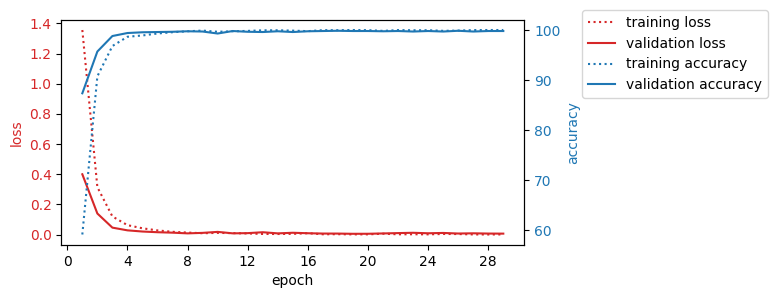


lr = 5e-05


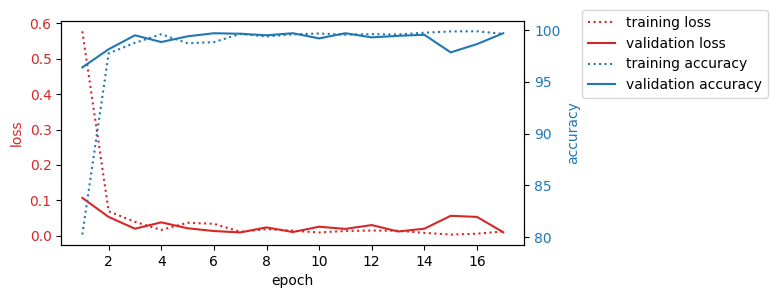


lr = 0.0001


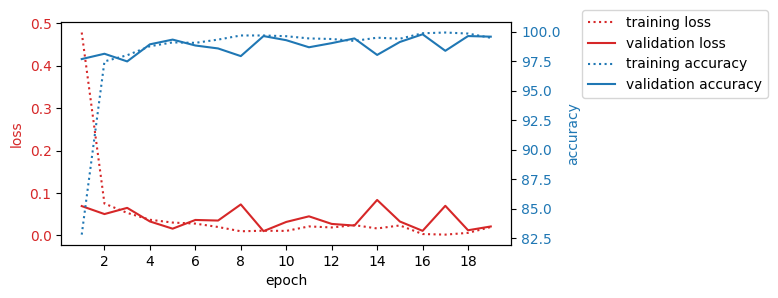


lr = 0.0005


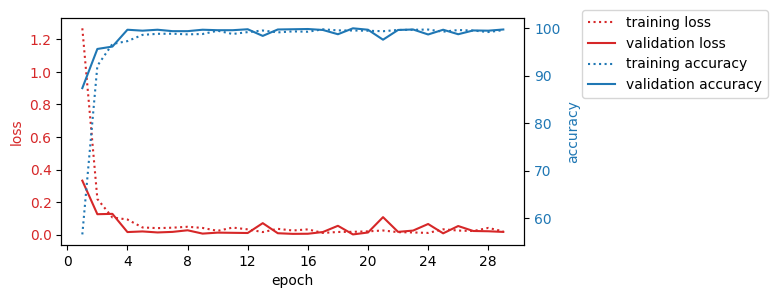

In [34]:
for lr in lrs:
    print(f"lr = {lr}")
    plotter0(model02_dict[lr])
    print()

In [35]:
# free up space
gc.collect()
torch.cuda.empty_cache()

# Test

In [36]:
amnist_test_dataloader = DataLoader(amnist_test_dataset, batch_size = 64, shuffle = True,generator = generator1)

In [38]:
# base test
for my_string in model02_strings:
    tester(my_string,amnist_test_dataloader,"tuple")
    print()

<ipython-input-30-87140b89c5cb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_string))


output/model_base_lr1e-05_20240827-104643.pth
Got 1993/2000 with accuracy 99.65


output/model_base_lr5e-05_20240827-105012.pth
Got 1991/2000 with accuracy 99.55


output/model_base_lr0.0001_20240827-105405.pth
Got 1994/2000 with accuracy 99.70


output/model_base_lr0.0005_20240827-110001.pth
Got 1998/2000 with accuracy 99.90


